In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import copy

import pandas as pd
import numpy as np
#import healpy as hp
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import minimize
from astropy.io import fits
#from tqdm import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
import iminuit
from iminuit import Minuit, describe, Struct
import re

# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis
rcParams['font.size'] = 15
rcParams['text.usetex'] = True

ModuleNotFoundError: No module named 'iminuit'

In [85]:
# Global settings
nside=128
emin = 0
emax = 39
mass = 100

In [86]:
# These are the energy bin edges over which the data is defined
ebins = 2*np.logspace(-1,3,41)[emin:emax+2]
my_iebins = [ 10, 20 ]

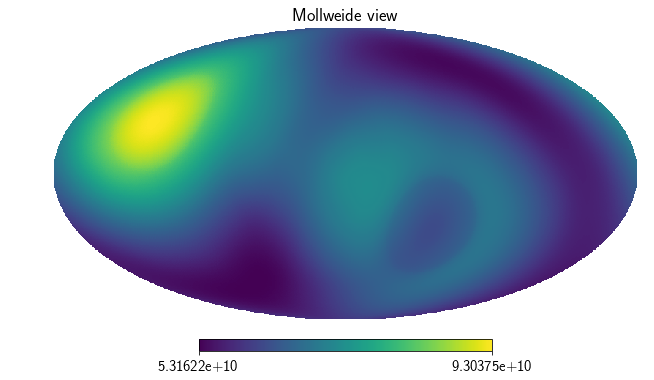

In [93]:
exposure_ebins= []
dif_ebins= []
iso_ebins= []
psc_ebins = []
data_ebins = []
for ib, b in enumerate(my_iebins[:-1]):
    fermi_exposure = np.zeros(len(np.load("maps/exposure0.npy")))
    dif = np.zeros(len(fermi_exposure))
    iso = np.zeros(len(fermi_exposure))
    psc = np.zeros(len(fermi_exposure))
    data = np.zeros(len(fermi_exposure))
    n = 0
    for bin_ind in range(b, my_iebins[ib+1]):
        n+=1
        fermi_exposure += np.load("maps/exposure"+str(bin_ind)+".npy")
        dif += np.load("maps/dif"+str(bin_ind)+".npy")
        iso += np.load("maps/iso"+str(bin_ind)+".npy")
        psc += np.load("maps/psc"+str(bin_ind)+".npy")
        data += np.load("maps/data"+str(bin_ind)+".npy")
    fermi_exposure = fermi_exposure / n
    exposure_ebins.append(fermi_exposure)
    dif_ebins.append(dif)
    iso_ebins.append(iso)
    psc_ebins.append(psc)
    data_ebins.append(data)
    np.save("exposure_ebins", exposure_ebins[0])
    np.save("dif_ebins", dif)
    np.save("iso_ebins", iso)
    np.save("psc_ebins", psc)
    np.save("data_ebins", data)
hp.mollview(exposure_ebins[0])

In [94]:
channel = 'b'
PPnoxsec_0 = [2.39E-05, 5.92280390900841E-06, 3.49364125167857E-07, 2.892785956280758e-09]
dNdLogx_df = pd.read_csv('/tigress/somalwar/Subhaloes/Subhalos/Data/AtProduction_gammas.dat', delim_\
whitespace=True)
dNdLogx_ann_df = dNdLogx_df.query('mDM == ' + (str(np.int(float(mass)))))[['Log[10,x]',channel]]
Egamma = np.array(mass*(10**dNdLogx_ann_df['Log[10,x]']))
dNdEgamma = np.array(dNdLogx_ann_df[channel]/(Egamma*np.log(10)))
dNdE_interp = interp1d(Egamma, dNdEgamma)
PPnoxsec_ebins = []
for ib, b in enumerate(my_iebins[:-1]):
    ebins_temp = [ ebins[b], ebins[my_iebins[ib+1]] ]
    if ebins_temp[0] < mass:
        if ebins_temp[1] < mass:
            # Whole bin is inside                                                                    
            PPnoxsec_ebins.append(1.0/(8*np.pi*mass**2)*quad(lambda x: dNdE_interp(x), ebins_temp[0]\
, ebins_temp[1])[0])
        else:
            # Bin only partially contained                                                           
            PPnoxsec_ebins.append(1.0/(8*np.pi*mass**2)*quad(lambda x: dNdE_interp(x), ebins_temp[0]\
, mass)[0])
    else: PPnoxsec_ebins.append(0)

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [95]:
subhalos = np.load('/tigress/somalwar/Subhaloes/Subhalos/MC/EinastoTemplate2.npy')
subhalos = subhalos

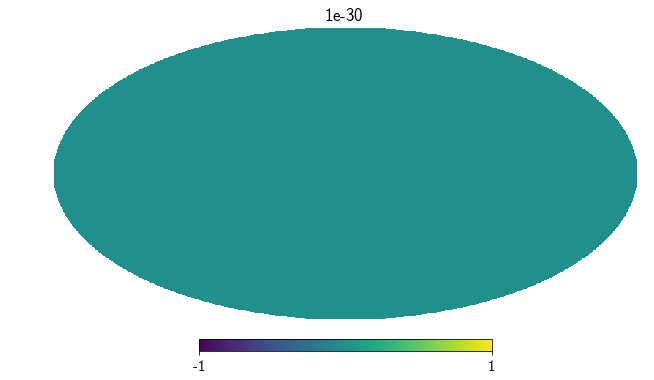

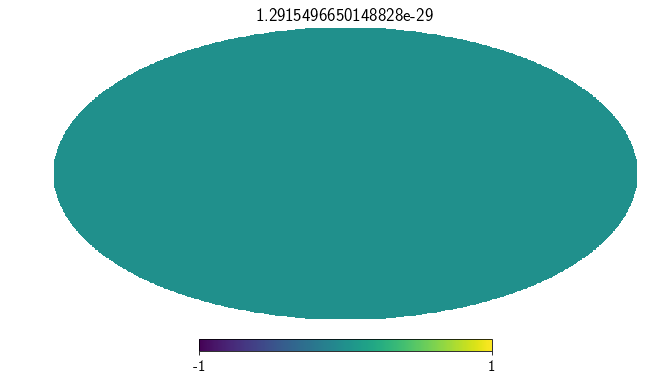

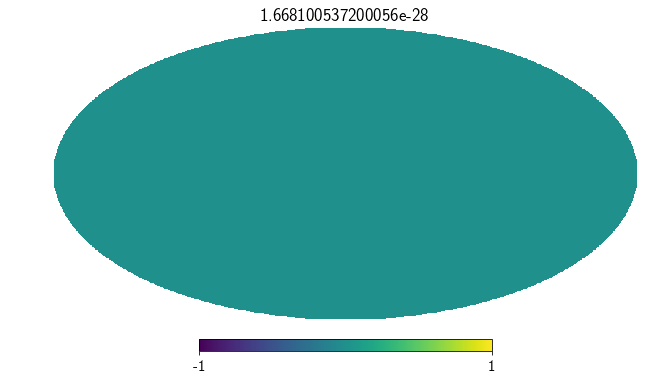

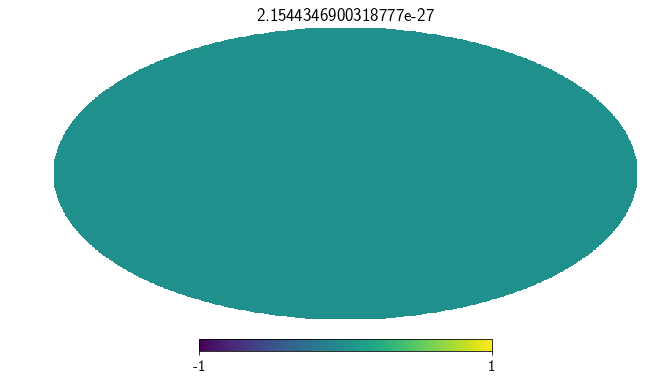

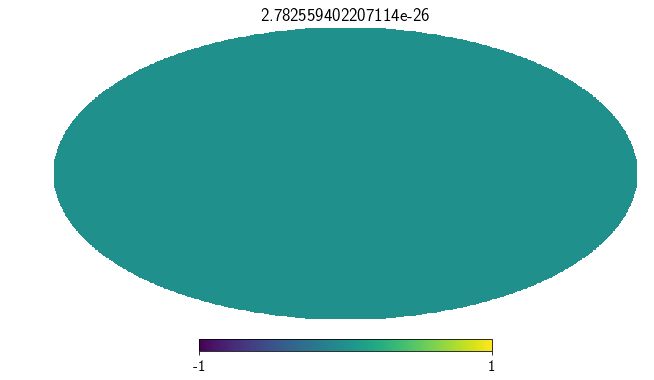

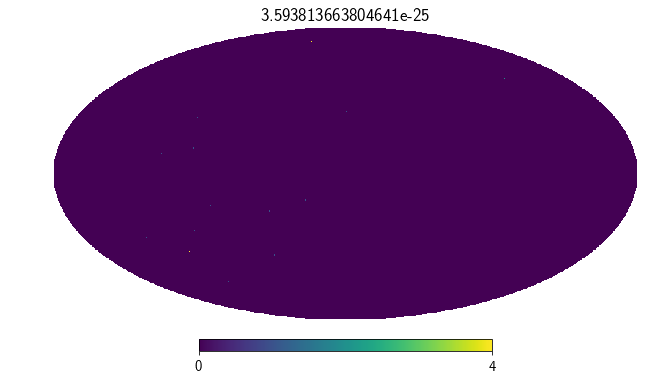

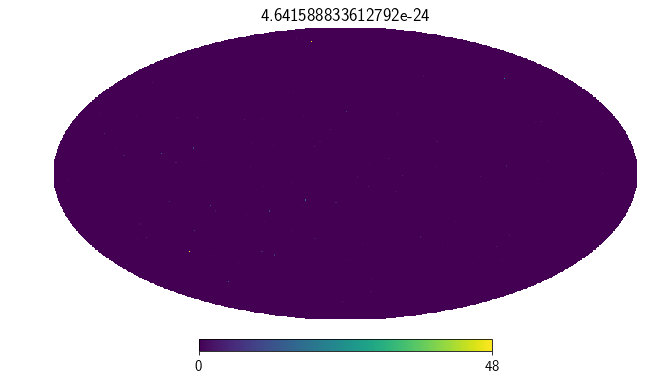

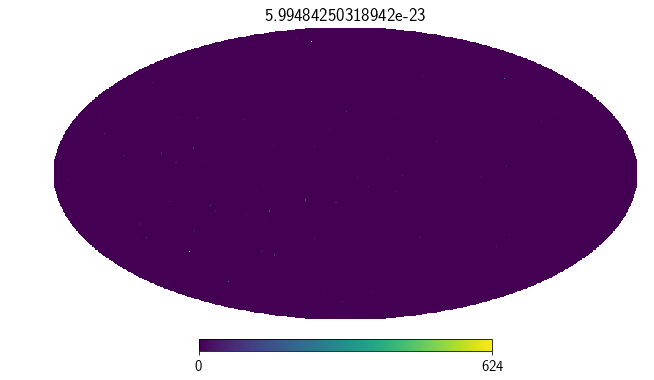

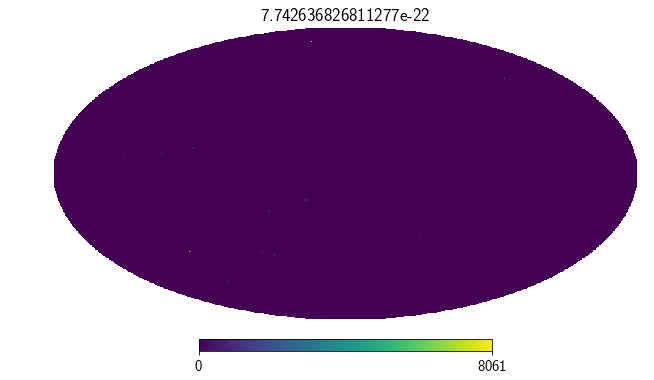

In [96]:
fake_data_arr_ebins = []
xsec_inj = np.logspace(-30, -20, 10)[:-1] #np.array([1e-22, 1e-25])
trials = 1
for ib, b in enumerate(my_iebins[:-1]):
    fake_data_arr = []
    for t in range(trials):
        fake_data_arr2 = []
        for fac in xsec_inj * 1e22:
            fake_data = 0.9095*dif_ebins[ib] + 0.0862*iso_ebins[ib] + 0.03719*psc_ebins[ib]
            fake_data = np.random.poisson(fake_data).astype(np.float64)
            fake_data = np.load("/tigress/somalwar/Subhaloes/Subhalos/MC/subhalo_flux_map"+str(t)+"_"+str(b)+"-"+str(my_iebins[ib+1])+".npy")*exposure_ebins[ib]*fac*PPnoxsec_ebins[ib]/PPnoxsec_0[ib]
            fake_data = np.round(fake_data).astype(np.int32)
            fake_data_arr2.append(fake_data)
            hp.mollview(fake_data, title=str(fac*1e-22))
        fake_data_arr.append(fake_data_arr2)
    fake_data_arr_ebins.append(fake_data_arr)

In [97]:
A0_ebins = np.array([-5.87473659])
n10_ebins = np.array([10.])
n20_ebins = np.array([1.79539639])
Fb0_ebins = np.array([3.10656124])

LL_xsec_ary_arr = []
new_n_arr_ebins = []
d_arr_ary = []
for ib, fake_data_arr in enumerate(fake_data_arr_ebins):
    new_n_arr2 = []
    for ix, fake_data_arr2 in enumerate(fake_data_arr):
        new_n_arr = []
        for fi, fake_data in enumerate(fake_data_arr2):
            n = nptfit.NPTF(tag='norm')
            n.load_data(fake_data, exposure_ebins[ib])
            pscmask=np.array(np.load('/tigress/somalwar/Subhaloes/Subhalos/fermi_data/fermidata_pscmask.npy'), dtype=bool)
            mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
            n.load_mask(mask)

            dif_copy = dif_ebins[ib].copy()
            iso_copy = iso_ebins[ib].copy()
            psc_copy = psc_ebins[ib].copy()
            subhalos_copy = subhalos.copy()

            n.add_template(dif_copy, 'dif')
            n.add_template(iso_copy, 'iso')
            n.add_template(psc_copy, 'psc')

            n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
            n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,20], False)
            n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,20], False)

            area_mask = len(mask[~mask])/len(mask) * 4*np.pi * (180/np.pi)**2
            xsec0 = 1e-22

            A0 = 10**A0_ebins[ib]
            n20 = n20_ebins[ib]
            n10 = n10_ebins[ib]
            Fb0 = 10**Fb0_ebins[ib] #*np.average(fermi_exposure_ebins[ib][~mask])    

            new_n = copy.copy(n)
            new_n.add_template(subhalos_copy, 'subhalos', units='PS')
            new_n.add_non_poiss_model('subhalos', 
                                   ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$F_b$'],
                                      fixed_params=[ [1,n10], [2,n20] ],
                                      units='counts')
            new_n.configure_for_scan(nexp=20)
            new_n_arr.append(new_n)
        new_n_arr2.append(new_n_arr)
    new_n_arr_ebins.append(new_n_arr2)

The number of parameters to be fit is 5
The number of parameters to be fit is 5
The number of parameters to be fit is 5
The number of parameters to be fit is 5
The number of parameters to be fit is 5
The number of parameters to be fit is 5
The number of parameters to be fit is 5
The number of parameters to be fit is 5
The number of parameters to be fit is 5


In [98]:
xsec_rec = []
xsec_test = np.logspace(-30, -20, 10)[:-1]
best_fit_params_arr = []
ll_xsec = []
for t in range(trials): 
    ll_xsec.append([])
    for ix in xsec_inj:
        ll_xsec[-1].append([])
print(ll_xsec)
for t in range(trials):
    for ix in tqdm_notebook(range(len(xsec_inj))):
        for xsec in xsec_test:
            ll = 0
            for ib in range(len(my_iebins[:-1])):
                A0 = 10**A0_ebins[ib]
                n20 = n20_ebins[ib]
                n10 = n10_ebins[ib]
                Fb0 = 10**Fb0_ebins[ib]
                minuit_min = iminuit.Minuit(lambda d, i, p: -new_n_arr_ebins[ib][t][ix].ll([d, i, p, A0/(xsec/xsec0), Fb0*(xsec/xsec0)]), d=0.9095, i=0.0862, p=0.03719, fix_d=False, fix_i=False, fix_p=False, limit_d=(0.,20.), limit_i=(0.,3.), limit_p=(0.,3.), error_d=1e-1, error_i=1e-1, error_p=1e-1, print_level=0);
                minuit_min.migrad();
                ll+=minuit_min.fval
            ll_xsec[t][ix].append(ll)

[[[], [], [], [], [], [], [], [], []]]


/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: InitialParamWarning: errordef is not given. Default to 1.
/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: InitialParamWarning: errordef is not given. Default to 1.
/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: InitialParamWarning: errordef is not given. Default to 1.
/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: InitialParamWarning: errordef is not given. Default to 1.
/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: InitialParamWarning: errordef is not given. Default to 1.
/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: InitialParamWarning: errordef is not given. Default to 1.
/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: InitialParamWarning: errordef is not given. Default to 1.
/tigress/somalwar/an

(-12, 3)

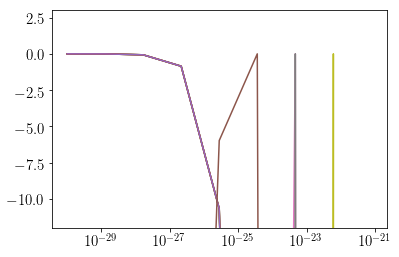

In [ ]:
xsec_rec = []
xsec_max = []
for t in range(trials):
    xsec_rec2 = []
    xsec_max2 = []
    for ix in range(len(xsec_inj)):
        ll_xsec[t][ix] = np.array(ll_xsec[t][ix])
        TS = -2*(ll_xsec[t][ix] - ll_xsec[t][ix][0])
        TS_max = np.amax(TS)
        argmax = np.argmax(TS)
        plt.plot(xsec_test, TS-TS_max)
        for ix, xsec in enumerate(xsec_test[argmax:]):
            if TS_max - TS[argmax+ix] > 2.71:
                xsec_rec2.append(xsec)
                xsec_max2.append(xsec_test[argmax])
                break
    xsec_rec.append(xsec_rec2)
    xsec_max.append(xsec_max2)
plt.xscale("log")
plt.ylim(-12, 3)

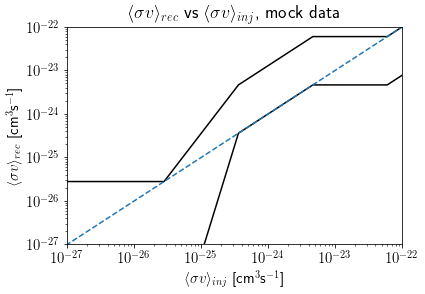

In [ ]:
xsec_rec_arr = []
xsec_max_arr = []
for ix in range(len(xsec_inj)):
    xsec_rec_arr2 = []
    xsec_max_arr2 = []
    for t in range(trials):
        xsec_rec_arr2.append(xsec_rec[t][ix])
        xsec_max_arr2.append(xsec_max[t][ix])
    xsec_rec_arr.append(xsec_rec_arr2)
    xsec_max_arr.append(xsec_max_arr2)
plt.plot(xsec_inj, np.percentile(xsec_rec_arr, 50, axis=1), c="black")
plt.plot(xsec_inj, np.percentile(xsec_max_arr, 50, axis=1), c="black")
plt.fill_between(xsec_inj, np.percentile(xsec_rec_arr, 2.5, axis=1), np.percentile(xsec_rec_arr, 97.5, axis=1), facecolor="yellow")
plt.fill_between(xsec_inj, np.percentile(xsec_rec_arr, 16, axis=1), np.percentile(xsec_rec_arr, 84, axis=1), facecolor="limegreen")
plt.plot(xsec_inj, xsec_inj, linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-27,1e-22)
plt.ylim(1e-27,1e-22)
plt.ylabel("$\\langle \\sigma v \\rangle_{rec}$ [cm$^3$s$^{-1}$]")
plt.xlabel("$\\langle \\sigma v \\rangle_{inj}$ [cm$^3$s$^{-1}$]")
plt.title("$\\langle \\sigma v \\rangle_{rec}$ vs $\\langle \\sigma v \\rangle_{inj}$, mock data")
#plt.legend()
plt.show()
plt.close()

[-2.78988692e-08 -2.78988692e-08 -2.78988692e-08 -2.78988692e-08
 -2.78988692e-08 -2.78988692e-08 -2.78988692e-08 -2.78988692e-08
 -2.78988692e-08 -2.78988692e-08 -2.78988692e-08 -2.78988692e-08
 -2.78988692e-08 -2.78988692e-08 -2.78988692e-08 -2.78988692e-08
 -2.79043165e-08 -2.79165940e-08 -2.79165940e-08 -2.79343189e-08
 -2.79366126e-08 -5.07245197e-07 -2.79874933e-08 -4.90453828e-07
 -2.80959671e-08 -2.81915814e-08 -2.83296896e-08 -2.85366191e-08
 -2.88429806e-08 -2.92945427e-08 -2.99630599e-08 -3.09519456e-08
 -3.24141057e-08 -3.45775281e-08 -3.77770538e-08 -4.25096932e-08
 -4.95097213e-08 -5.98635065e-08 -7.51778616e-08 -9.78295847e-08
 -1.31333848e-07 -1.80890290e-07 -2.54189456e-07 -3.62607051e-07
 -5.22968390e-07 -7.60160265e-07 -1.11099265e-06 -1.62991188e-06
 -2.39744951e-06 -3.53272100e-06 -5.21191048e-06 -7.69561368e-06
 -1.13692797e-05 -1.68030297e-05 -2.48401343e-05 -3.67278816e-05
 -5.43111456e-05 -8.03186919e-05 -1.18786657e-04 -1.75684915e-04
 -2.59843536e-04 -3.84323

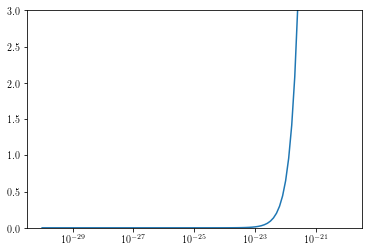

In [18]:
file = np.load("BlazarsTests/Results/NoBlazNoBkgFloatBlaz/lim_4.893900918477499e-30_siginj_flblaz_temp_4.893900918477499e-30_0_siginj_.npz")
plt.plot(np.logspace(-30,-20,101), -file['arr_1'] + max(file['arr_1']))
plt.xscale("log")
#plt.yscale("log")
plt.ylim(0,3)
print(file['arr_1'])
print(file['arr_0'])